# 1. Dependências e dataset

In [1]:
## Load dependencies.
import pandas as pd
import numpy as np
from global_functions import dynamic_group
from scipy.stats import mstats
from sklearn.preprocessing import PowerTransformer
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import re
import seaborn as sns
from plotnine import *
import plotnine
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMModel
from lightgbm import LGBMClassifier
import shap


In [2]:
## Load main dataset.
df = pd.read_csv('bases-ajustadas/operacoes-integrado.csv')

In [3]:
## Define columns to drop.
drop_cols = ['cnpj', 'data_da_contratacao', 'valor_contratado_reais', 'valor_desembolsado_reais', 'modalidade_de_apoio',
 'instrumento_financeiro', 'custo_financeiro','area_operacional', 'subsetor_bndes', 'situacao_do_contrato', 'mes', 'igpm',
  'valor_contratado_ajustado','ano', 'num_empregados', 'emissao_co2', 'pib', 'idhm', 'cliente', 'juros', 'prazo_carencia_meses',
    'prazo_amortizacao_meses', 'inovacao']

## Drop.
df.drop(drop_cols, axis=1, inplace=True)


In [3]:
## Define columns to drop.
drop_cols = ['numero_do_contrato', 'data_da_contratacao', 'valor_contratado_reais', 'valor_desembolsado_reais', 'modalidade_de_apoio',
             'instrumento_financeiro', 'custo_financeiro', 'area_operacional', 'subsetor_bndes', 'situacao_do_contrato', 'mes', 'igpm',
             'valor_contratado_ajustado', 'ano', 'num_empregados', 'emissao_co2', 'pib', 'idhm', 'cliente', 'inovacao',
             'juros', 'prazo_carencia_meses']

## Drop.
df.drop(drop_cols, axis=1, inplace=True)


In [5]:
## Group by cliente
gvars = ['cnpj']
rules = {'uf': 'first', 'produto': 'first', 'fonte_de_recurso_desembolsos': 'first', 'setor_bndes': 'first',
         'porte_do_cliente': 'first', 'natureza_do_cliente': 'first', 'tipo_de_garantia': 'first',
         'valor_desembolsado_ajustado': 'sum', 'processos': 'mean',
         'prazo_amortizacao_meses':'mean'}
df = dynamic_group(df, gvars, rules)
## Remove cnpj number
df.drop(['cnpj'], axis=1, inplace=True)

In [4]:
## Group by contracts
gvars = ['numero_do_contrato']
rules = {'uf': 'first', 'produto':'first', 'fonte_de_recurso_desembolsos':'first', 'setor_bndes':'first',
    'porte_do_cliente':'first', 'natureza_do_cliente':'first', 'tipo_de_garantia':'first',
    'valor_desembolsado_ajustado':'sum', 'processos':'mean'}
df = dynamic_group(df, gvars, rules)


In [39]:
## Remove contract number
df.drop(['numero_do_contrato'], axis=1, inplace=True)

KeyError: "['numero_do_contrato'] not found in axis"

# 2. Verificação de integridade dos dados e ajustes

Como observamos que as firmas grandes tem características muito distintas das outras, iremos trabalhar apenas com esse grupo de empresas. 

In [6]:
## Keep only 'grande' firms.
df = df.loc[df['porte_do_cliente'] == 'GRANDE']

In [7]:
## Groupping fonte de recursos do desembolso.
df['fonte_de_recurso_desembolsos'] = [re.sub('^RECURSOS LIVRES\s-.*', "RECURSOS LIVRES", elem)
                                      for elem in df['fonte_de_recurso_desembolsos']]

df['fonte_de_recurso_desembolsos'] = [re.sub('^RECURSOS VINCULADOS\s-.*', "RECURSOS VINCULADOS", elem)
                                      for elem in df['fonte_de_recurso_desembolsos']]

df['fonte_de_recurso_desembolsos'] = [re.sub('^RECURSOS ESTATUTÁRIOS\s-.*', "RECURSOS ESTATUTÁRIOS", elem)
                                      for elem in df['fonte_de_recurso_desembolsos']]


In [8]:
## drop 'porte_do_cliente'.
df.drop(['porte_do_cliente'], axis=1, inplace=True)

In [9]:
## DF shape.
df.shape

(1870, 9)

In [9]:
# Change null value to NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [10]:
## Verify NA's
df.isna().sum()

uf                              0
produto                         0
fonte_de_recurso_desembolsos    0
setor_bndes                     0
natureza_do_cliente             0
tipo_de_garantia                0
valor_desembolsado_ajustado     0
processos                       0
juros                           0
prazo_carencia_meses            0
prazo_amortizacao_meses         0
dtype: int64

In [11]:
## Verify if numerical variables are negative or 0
numerical = ['valor_desembolsado_ajustado', 'processos']

## Checking 0's and negative values.
for itens in numerical:
    zeros = len(df.loc[df[itens] == 0])
    negatives = len(df.loc[df[itens] < 0])

    print('Variável', itens, 'tem um total de ', zeros, 'valores 0 e ', negatives, 'valores negativos')


Variável valor_desembolsado_ajustado tem um total de  0 valores 0 e  0 valores negativos
Variável processos tem um total de  245 valores 0 e  0 valores negativos


Variáveis númericas não apresentam dados inexplicáveis.
O método de normalização utilizado será o 'box-cox', que só aceita valores estritamente positivos. Para não perdermos as 357 observações, iremos as substituir pelo valor mínimo de 1, que não deve alterar a propriedade destas empresas.

In [44]:
df['processos'] = df['processos'].replace(0, 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
## Verify column types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   uf                            1870 non-null   object 
 1   produto                       1870 non-null   object 
 2   fonte_de_recurso_desembolsos  1870 non-null   object 
 3   setor_bndes                   1870 non-null   object 
 4   natureza_do_cliente           1870 non-null   object 
 5   tipo_de_garantia              1870 non-null   object 
 6   valor_desembolsado_ajustado   1870 non-null   float64
 7   processos                     1870 non-null   float64
 8   juros                         1870 non-null   float64
 9   prazo_carencia_meses          1870 non-null   float64
 10  prazo_amortizacao_meses       1870 non-null   float64
dtypes: float64(5), object(6)
memory usage: 160.8+ KB


Os dados estão corretamente configurados, agradecimento ao nosso time de engenharia de dados ;)

Como observamos no EDA, a amostra está repleta de outliers. Amenizaremos este problema winsorizando as variáveis valor_desembolsado_ajustado e processos em 5%

In [45]:
## 5% winsorizing
df['valor_desembolsado_ajustado'] = mstats.winsorize(
    df['valor_desembolsado_ajustado'], limits=[0.05, 0.05])

df['processos'] = mstats.winsorize(
    df['processos'], limits=[0.05, 0.05])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
## Reseting dataset index.
df.index = pd.RangeIndex(len(df.index))

# 3. Clusterização por k-prototype

Nesta etapa tal tal

In [47]:
## Define clusterization dataset.
kdata = df.copy(deep=True)

In [48]:
## Standardize numerical data.
for floats in df.select_dtypes(exclude='object').columns:
    pt = PowerTransformer(method='box-cox', standardize=True)
    kdata[floats] = pt.fit_transform(np.array(kdata[floats]).reshape(-1, 1))

In [49]:
## Define categorical columns.
print(df.columns)
categorical_columns = [0, 1, 2, 3, 4, 5]


Index(['uf', 'produto', 'fonte_de_recurso_desembolsos', 'setor_bndes',
       'natureza_do_cliente', 'tipo_de_garantia',
       'valor_desembolsado_ajustado', 'processos', 'prazo_amortizacao_meses'],
      dtype='object')


In [50]:
## Elbow cost method.
cost = []

for cluster in range(1,5):
    try:
        kproto = KPrototypes(n_jobs = 5, n_clusters=cluster, init='huang', random_state=0)
        kproto.fit_predict(kdata, categorical=categorical_columns)
        cost.append(kproto.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        print(f"Can't cluster with {cluster} clusters")


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4


In [51]:
## Converting the results into a dataframe.
df_cost = pd.DataFrame({'Cluster': range(1, 5), 'Cost': cost})


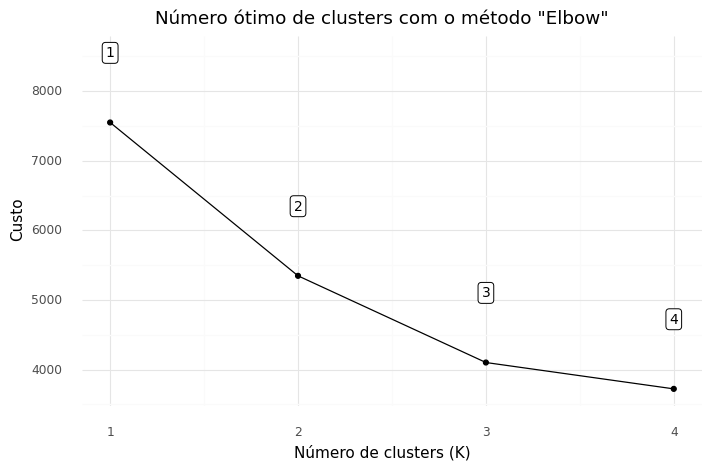

<ggplot: (8731593210474)>

In [52]:
# Plotting cost x number of clusters.
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data=df_cost) +
    geom_line(aes(x='Cluster',
                  y='Cost')) +
    geom_point(aes(x='Cluster',
                   y='Cost')) +
    geom_label(aes(x='Cluster',
                   y='Cost',
                   label='Cluster'),
               size=10,
               nudge_y=1000) +
    labs(title='Número ótimo de clusters com o método "Elbow"') +
    xlab('Número de clusters (K)') +
    ylab('Custo') +
    theme_minimal()
)


In [53]:
## Clusterizing wth 3 clusters.
kprototype = KPrototypes(n_jobs=5, n_clusters=3, init='Huang', random_state=0)
kprototype.fit_predict(kdata, categorical=categorical_columns)


array([0, 2, 1, ..., 0, 2, 2], dtype=uint16)

In [54]:
kdata['cluster'] = kprototype.labels_

1    789
2    568
0    513
Name: cluster, dtype: int64


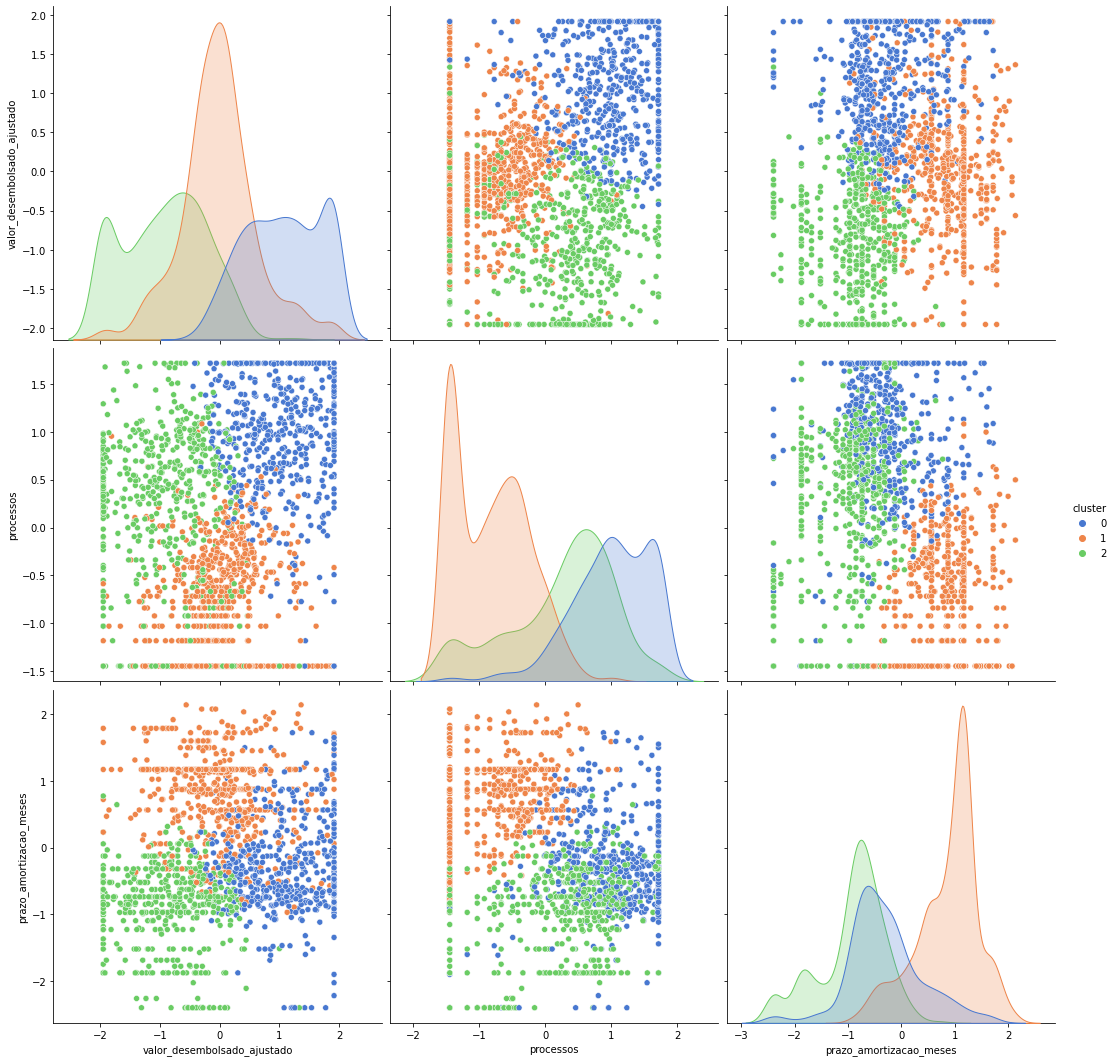

In [55]:
#Visualize K-Prototype clustering
print(kdata['cluster'].value_counts())
sns.pairplot(kdata,
 hue='cluster',
 palette='muted',
 diag_kind='kde',
 height=5,
 aspect=1)  

In [56]:
# Create train dataset and set objects to category
train_data = df.copy(deep=True)
for c in train_data.select_dtypes(include='object'):
    train_data[c] = train_data[c].astype('category')


In [57]:
clf_kp = LGBMClassifier(colsample_bytree=0.8)
cv_scores_kp = cross_val_score(
    clf_kp, train_data, kdata['cluster'], scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')


CV F1 score for K-Prototypes clusters is 0.9636180319052059


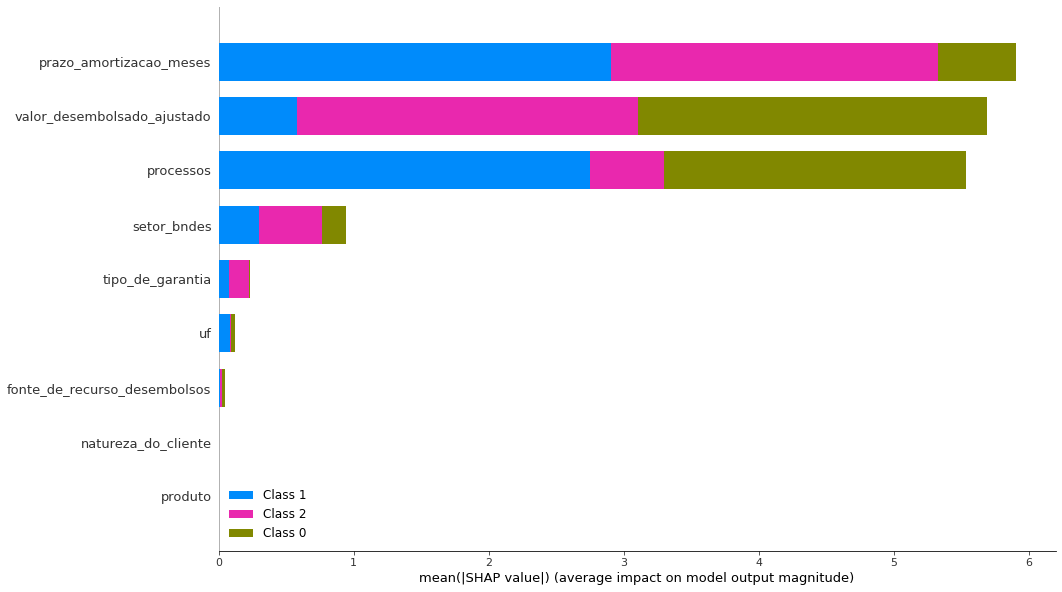

In [58]:
model = clf_kp.fit(train_data, kdata['cluster'])
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data)
shap.summary_plot(shap_values, train_data,
                   plot_size=(15, 10))

# 4. Diferenças de variáveis entre clusters

In [59]:
## Mean 'desembolso'.
for cluster in range(0,3):
        index = kdata.loc[kdata['cluster'] == cluster].index
        mean = round(df.iloc[index, 6].mean(), 2)
        print('Cluster', cluster, 'Média de financiamento por contrato: R$', mean)

Cluster 0 Média de financiamento por contrato: R$ 529626661.59
Cluster 1 Média de financiamento por contrato: R$ 114265942.02
Cluster 2 Média de financiamento por contrato: R$ 31641847.55


In [60]:
## Mean 'processos':
for cluster in range(0, 3):
    index = kdata.loc[kdata['cluster'] == cluster].index
    processos = round(df.iloc[index, 7].mean())
    print('Cluster', cluster, 'Média de processos jurídicos por empresa:', processos, 'processos.')


Cluster 0 Média de processos jurídicos por empresa: 3263 processos.
Cluster 1 Média de processos jurídicos por empresa: 21 processos.
Cluster 2 Média de processos jurídicos por empresa: 709 processos.


In [42]:
## UF frequency per cluster.
for cluster in range(0, 3):
    index = kdata.loc[kdata['cluster'] == cluster].index
    cat_counts = list(dict(round(df.iloc[index, 0].value_counts(normalize=True)*100, 2)).items())
    cat = list(df.columns)[0]
    print()
    print('Cluster', cluster, 'Categorias (%) mais frequentes de', cat, ':')
    print(cat_counts[0:3])



Cluster 0 Categorias (%) mais frequentes de uf :
[('BA', 17.93), ('RN', 11.76), ('RS', 9.62)]

Cluster 1 Categorias (%) mais frequentes de uf :
[('SP', 26.11), ('IE', 11.11), ('RJ', 9.07)]

Cluster 2 Categorias (%) mais frequentes de uf :
[('SP', 32.79), ('RS', 12.09), ('MG', 9.43)]


In [43]:
## Produto frequency per cluster.
for cluster in range(0, 3):
    index = kdata.loc[kdata['cluster'] == cluster].index
    cat_counts = list(
        dict(round(df.iloc[index, 1].value_counts(normalize=True)*100, 2)).items())
    cat = list(df.columns)[1]
    print()
    print('Cluster', cluster, 'Categorias (%) mais frequentes de', cat, ':')
    print(cat_counts[0:3])



Cluster 0 Categorias (%) mais frequentes de produto :
[('BNDES FINEM', 57.6), ('BNDES PROJECT FINANCE', 34.32), ('BNDES EMPRÉSTIMO PONTE', 7.36)]

Cluster 1 Categorias (%) mais frequentes de produto :
[('BNDES FINEM', 80.56), ('BNDES PROJECT FINANCE', 10.93), ('BNDES EMPRÉSTIMO PONTE', 7.22)]

Cluster 2 Categorias (%) mais frequentes de produto :
[('BNDES FINEM', 96.31), ('BNDES PROJECT FINANCE', 2.05), ('BNDES LIMITE DE CRÉDITO', 1.02)]


In [44]:
## fonte_de_recursos frequency per cluster.
for cluster in range(0, 3):
    index = kdata.loc[kdata['cluster'] == cluster].index
    cat_counts = list(
        dict(round(df.iloc[index, 2].value_counts(normalize=True)*100, 2)).items())
    cat = list(df.columns)[2]
    print()
    print('Cluster', cluster, 'Categorias (%) mais frequentes de', cat, ':')
    print(cat_counts[0:3])



Cluster 0 Categorias (%) mais frequentes de fonte_de_recurso_desembolsos :
[('RECURSOS LIVRES', 96.08), ('RECURSOS VINCULADOS', 3.68), ('RECURSOS ESTATUTÁRIOS', 0.24)]

Cluster 1 Categorias (%) mais frequentes de fonte_de_recurso_desembolsos :
[('RECURSOS LIVRES', 94.81), ('RECURSOS VINCULADOS', 5.19)]

Cluster 2 Categorias (%) mais frequentes de fonte_de_recurso_desembolsos :
[('RECURSOS LIVRES', 96.93), ('RECURSOS VINCULADOS', 3.07)]


In [45]:
## setor_bndes frequency per cluster.
for cluster in range(0, 3):
    index = kdata.loc[kdata['cluster'] == cluster].index
    cat_counts = list(
        dict(round(df.iloc[index, 3].value_counts(normalize=True)*100, 2)).items())
    cat = list(df.columns)[3]
    print()
    print('Cluster', cluster, 'Categorias (%) mais frequentes de', cat, ':')
    print(cat_counts[0:3])



Cluster 0 Categorias (%) mais frequentes de setor_bndes :
[('INFRAESTRUTURA', 86.94), ('INDUSTRIA', 11.76), ('AGROPECUARIA', 1.31)]

Cluster 1 Categorias (%) mais frequentes de setor_bndes :
[('INFRAESTRUTURA', 57.59), ('INDUSTRIA', 38.52), ('AGROPECUARIA', 3.89)]

Cluster 2 Categorias (%) mais frequentes de setor_bndes :
[('INDUSTRIA', 67.62), ('INFRAESTRUTURA', 25.41), ('AGROPECUARIA', 6.97)]


In [195]:
## natureza_do_cliente frequency per cluster.
for cluster in range(0, 3):
    index = kdata.loc[kdata['cluster'] == cluster].index
    cat_counts = list(
        dict(round(df.iloc[index, 4].value_counts(normalize=True)*100, 2)).items())
    cat = list(df.columns)[4]
    print()
    print('Cluster', cluster, 'Categorias (%) mais frequentes de', cat, ':')
    print(cat_counts[0:3])



Cluster 0 Categorias (%) mais frequentes de natureza_do_cliente :
[('PRIVADA             ', 94.65), ('ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO MUNICIPAL', 2.75), ('PÚBLICA INDIRETA', 2.4)]

Cluster 1 Categorias (%) mais frequentes de natureza_do_cliente :
[('PRIVADA             ', 85.92), ('PÚBLICA INDIRETA', 7.82), ('ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO ESTADUAL', 4.05)]

Cluster 2 Categorias (%) mais frequentes de natureza_do_cliente :
[('PRIVADA             ', 92.39), ('PÚBLICA INDIRETA', 5.87), ('ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO ESTADUAL', 0.87)]


In [198]:
## tipo_de_garantia frequency per cluster.
for cluster in range(0, 3):
    index = kdata.loc[kdata['cluster'] == cluster].index
    cat_counts = list(
        dict(round(df.iloc[index, 5].value_counts(normalize=True)*100, 2)).items())
    cat = list(df.columns)[5]
    print()
    print('Cluster', cluster, 'Categorias (%) mais frequentes de', cat, ':')
    print(cat_counts[0:3])



Cluster 0 Categorias (%) mais frequentes de tipo_de_garantia :
[('DEFINIDA PELO AGENTE FINANCEIRO', 32.67), ('PESSOAL', 27.45), ('REAL / PESSOAL', 23.61)]

Cluster 1 Categorias (%) mais frequentes de tipo_de_garantia :
[('PESSOAL', 31.28), ('REAL / PESSOAL', 22.54), ('REAL', 15.09)]

Cluster 2 Categorias (%) mais frequentes de tipo_de_garantia :
[('REAL / PESSOAL', 51.86), ('DEFINIDA PELO AGENTE FINANCEIRO', 16.89), ('PESSOAL', 15.31)]
